<a href="https://colab.research.google.com/github/landerlini/mlinfn-advanced-hackathon/blob/main/ex/gnn_transformers/TransformerSG_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-INFN Hackathon: Advanced Level
## Hands-on on Transformers

In this session, we will try to implement a transformer architecture and to train it for a tipical high energy physics task: jet tagging (e.g. classification of jets originating from different particles: *gluons, quarks, Ws, Zs, and top quarks*.

At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters and charged tracks parameters reconsrtcuted in the inner tracker, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The jet constituents can be in fact represented either as 2D or 3D images,lending itself to the natural application of image classification techniques (CNN, ViT etc.), or as pointclouds/graphs, that can be classified with GNNs, or as sequences, that can be analysed by RNNs or Transformers.

The dataset is the *JetDataset* also used for the GNN tutorial and introduced in the previous hands-on session. 

We use the original transformer architecture of *A.Vaswani et al. “Attention is All You Need” (2017) [arXiv:1706.03762](https://arxiv.org/abs/1706.03762)*, by using only the transformer encoder part, with multi-head attentions+MLP blocks. We also adopt a pre-layer normalization (in addition to the original post-layer normalization) as suggested by *R.Xiong et al. "On Layer Normalization in the Transformer Architecture" (2020) [pdf](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)*.  

The implementation is done using pure [PyTorch](https://pytorch.org) APIs.

For infos, latest version of the notebook, etc., contact Stefano Giagu: email: <stefano.giagu@uniroma1.it>, web: [https://www.giagu.it](https://www.giagu.it) 

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

1.12.1+cu113
0.13.1+cu113


In [2]:
# dataset download
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

Cloning into 'tutorials'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 690 (delta 51), reused 92 (delta 32), pack-reused 579
Receiving objects: 100% (690/690), 565.84 MiB | 17.99 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Checking out files: 100% (75/75), done.
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [3]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla T4
Computation device: cuda



## Data Handling

The dataset consists of a list of jets. For each jet, we have up to 100 particles (zero-padding is used in case a jet has less than 100 particles). 

For each particle, we have 16 features:

* the four-moemntum in cartesian coordinates (, , , )
* the energy divided by the jet energy ()
* the transverse momentum (), i.e. the momentum projected on the plane transverse to proton beams
* the momentum transverse to the jet direction ()
* the pseudorapidity (), a function of the polar angle (see https://en.wikipedia.org/wiki/Pseudorapidity)
* the pseudorapidity relative to the jet direction ()
* the pseudorapidity relative to the jet direction () after a rotation is applied so that the jet image looks vertical
* the azimuth angle ()
* the azimuth angle relative to the jet direction ()
* the azimuth angle relative to the jet direction () after a rotation is applied so that the jet image looks vertical
* ID of the particle (see https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf)

The ground truth is incorporated in the *['j_g', 'j_q', 'j_w', 'j_z', 'j_t]* vector of boolean, taking the form:

* $[1, 0, 0, 0, 0]$ for gluons
* $[0, 1, 0, 0, 0]$ for quarks
* $[0, 0, 1, 0, 0]$ for W bosons (with W  qq)
* $[0, 0, 0, 1, 0]$ for Z bosons (with Z  qq)
* $[0, 0, 0, 0, 1]$ for top quarks (with t  Wq  qqq)

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems).

In [4]:
# read dataset (only 50k events to keep training time ~20')
target = np.array([])
p_data = np.array([])
datafiles = [#'tutorials/Data/JetDataset/jetImage_7_100p_80000_90000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_70000_80000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']

for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    data = np.array(f.get("jetConstituentList")) #jet constituents
    targ = np.array(f.get('jets')[0:,-6:-1])  #select ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] out of the 59 features presents in the container
    p_data = np.concatenate([p_data, data], axis=0) if p_data.size else data
    target = np.concatenate([target, targ], axis=0) if target.size else targ
    del data, targ
    f.close()

print(target.shape, p_data.shape)

p_featurenames = ['j1_px','j1_py','j1_pz','j1_e','j1_erel','j1_pt','j1_ptrel',
 'j1_eta','j1_etarel','j1_etarot','j1_phi','j1_phirel','j1_phirot',
 'j1_deltaR','j1_costheta','j1_costhetarel','j1_pdgid']

print(p_featurenames)

Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)
['j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_pdgid']


In [5]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

# this function makes the histogram of a given quantity for the five classes
def makePlot_p(feature_index, input_data, input_featurenames):
    plt.subplots()
    for i in range(len(labels)):
        my_data = input_data[:,:,feature_index]
        # notice the use of numpy masking to select specific classes of jets
        my_data = my_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index].flatten(), 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log', nonposy='clip')    
    plt.legend(labels, fontsize=12, frameon=False)  
    plt.xlabel(input_featurenames[feature_index], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

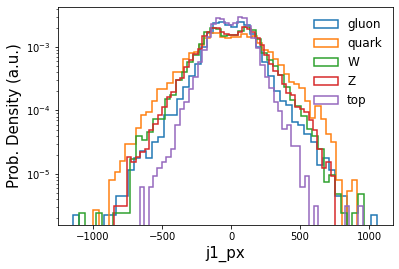

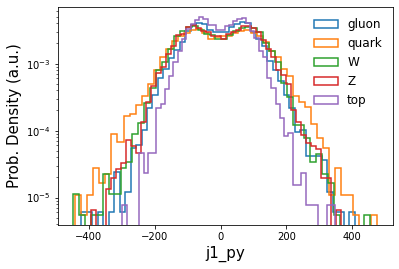

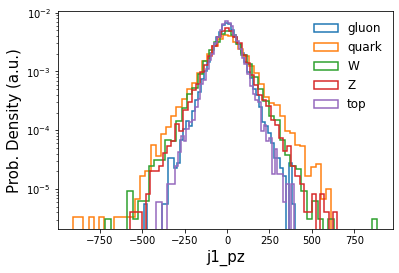

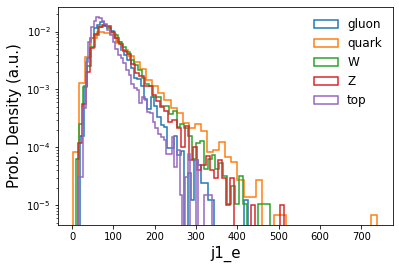

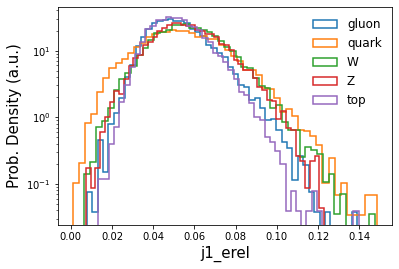

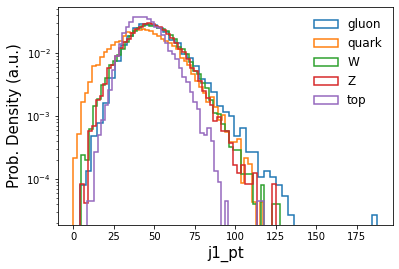

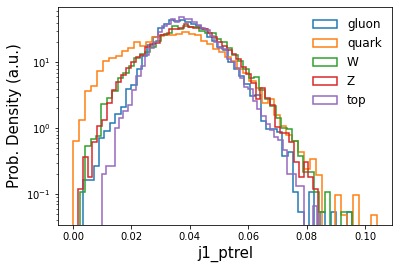

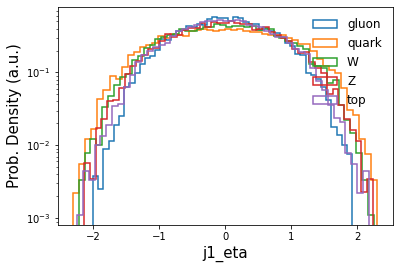

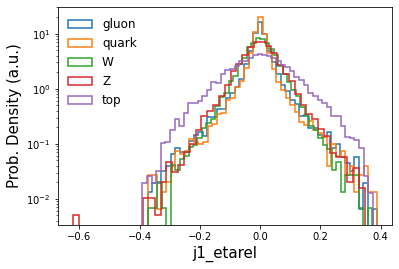

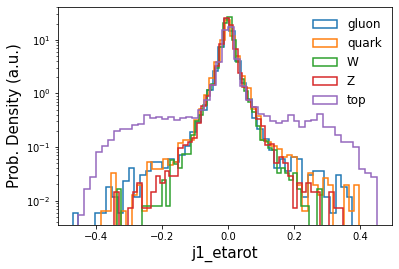

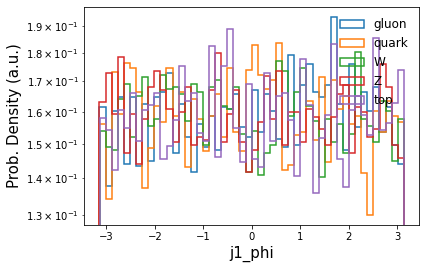

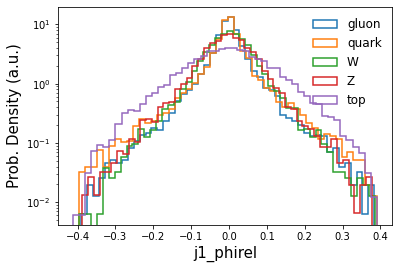

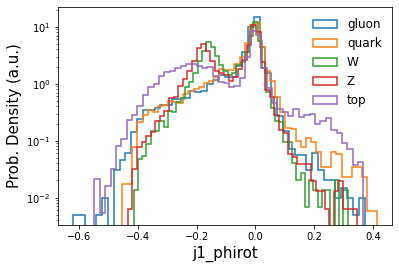

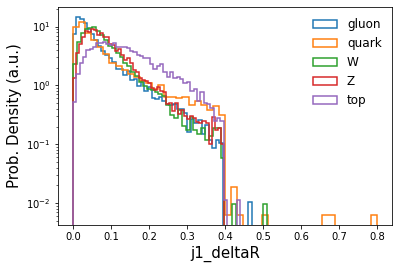

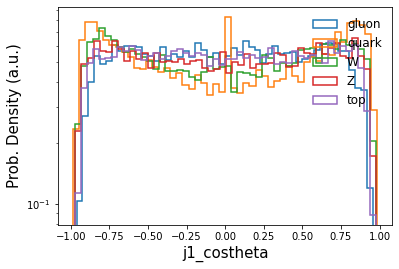

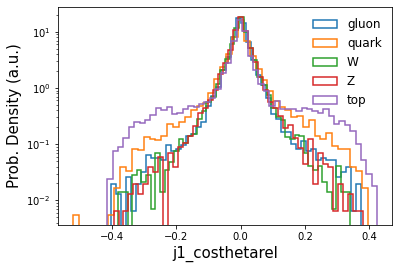

In [6]:
# we now plot all the features
for i in range(len(p_featurenames)-1):
    makePlot_p(i, p_data, p_featurenames)

In [7]:
# convert one-hot lables in integers labels, split and normalize data

p_label = np.argmax(target, axis=1) 

data_notnorm = np.array(p_data)

# training, validation, test split
from sklearn.model_selection import train_test_split
training_frac = 0.6 # training set fraction wrt whole sample
testset_frac = 0.25 # test set fraction wrt validation set

X_train,X_test,Y_train,Y_test = train_test_split(data_notnorm,p_label,train_size=training_frac, shuffle=True, random_state=1234)
X_vali,X_test,Y_vali,Y_test = train_test_split(X_test,Y_test,test_size=testset_frac, shuffle=True, random_state=1234)

print(X_train.shape)
print(X_vali.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_vali.shape)
print(Y_test.shape)

from sklearn.preprocessing import MinMaxScaler ,StandardScaler
scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_vali_norm = scaler.transform(X_vali.reshape(-1,X_vali.shape[-1])).reshape(X_vali.shape)
X_test_norm = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
print(X_train_norm.shape)
print(X_vali_norm.shape)
print(X_test_norm.shape)

(30000, 100, 16)
(15000, 100, 16)
(5000, 100, 16)
(30000,)
(15000,)
(5000,)
(30000, 100, 16)
(15000, 100, 16)
(5000, 100, 16)


**Exercise:** convert the numpy arrays in torch tensors

**Tipp:**
Use the torch.Tensor(numpy vector).float() or .int() methods 

In [8]:
# convert numpy arrays to torch tensors 

data_tr = torch.Tensor(X_train_norm).float()
label_tr = torch.Tensor(Y_train).int()
data_va = torch.Tensor(X_vali_norm).float()
label_va = torch.Tensor(Y_vali).int()
data_te = torch.Tensor(X_test_norm).float()
label_te = torch.Tensor(Y_test).int()

print(data_tr.shape)
print(label_tr.shape)
print(data_va.shape)
print(label_va.shape)
print(data_te.shape)
print(label_te.shape)

torch.Size([30000, 100, 16])
torch.Size([30000])
torch.Size([15000, 100, 16])
torch.Size([15000])
torch.Size([5000, 100, 16])
torch.Size([5000])


**Exercise:** create torch dataset and dataloaders

**Tipp:**
Use torch.utils.data.TensorDataset and torch.utils.data.DataLoader methods

NOTE: for the DataLoader of the traing set use the *shuffle=True*, and *drop_last=True* arguments

In [9]:
# torch datasets
from torch.utils.data import TensorDataset, DataLoader

dataset_tr = TensorDataset(data_tr, label_tr)
dataset_va = TensorDataset(data_va, label_va)
dataset_te = TensorDataset(data_te, label_te) 

print(len(dataset_tr))
print(len(dataset_va))
print(len(dataset_te))

30000
15000
5000


In [10]:
# torch dataloader/batching
from torch.utils.data import DataLoader

batch=64 #batch size

train_loader = DataLoader(dataset_tr, batch_size=batch, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(dataset_va, batch_size=batch, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(dataset_te, batch_size=batch, shuffle=False, drop_last=False, num_workers=2)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

468
235
79


## Transformer architecture

We define two python classes inheriting from pytroch nn.Module:

* *AttentionBlock*: implements the standard attention (multi-head attention + MLP) block for a tranformer encoder architecture
* *MyTransformer*: a classifier based on a transformer encoder architecture implementation

**Exercise:** for the AttentionBlock define an *mlp* block made by a Linear layer with GELU activation, a dropout layer, another Linear layer w/o activation floowed by another dropout layer.

The *mlp* takes in input a tensor with dimension *embed_dim*, and output a tensor with the same dimension. The hidden layers have *hidden_dim* neurons. The two dropout layers uses the same *dropout* probability. 

**Tipp:**
Use a nn.Sequential() model for the mlp containing nn.Linear, nn.GELU, nn.Dropout layers.

In [11]:
class AttentionBlock(nn.Module):
    #  Implements the standard attention (multi-head attention + MLP) block for 
    #  a tranformer encoder architecture

    #  structure: 
    #   MHA: pre layer normalization (see Ruibin Xiong et al. (2020)) + multi-head attention (pytorch implementation) + layer normalization
    #   MLP: dense + gelu + droput + dense + dropout   

    #  arguments:
    #   embed_dim  - Dimensionality of input and attention feature vectors
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network 
    #                (usually 2-4x larger than embed_dim)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   dropout    - Amount of dropout to apply in the feed-forward network

    #    ^
    #    |_____    NOR2(x) + NOR2(MHA(NOR1(x))) + MLP(NOR2(MHA(NOR1(x)))): output (L,B,embde_dim)
    #    |     ^
    #  -----   |
    # | MLP |  |
    #  -----   |
    #    |_____|
    #    |     
    #  -----  
    # | NOR |  
    #  -----   
    #    |_____    x + MHA(NOR1(x))
    #    |     ^
    #  -----   |
    # | MHA |  |
    #  -----   |
    #    |     |
    #  -----   |
    # | NOR |  |
    #  -----   | 
    #    |_____|
    #    |        x    

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super(AttentionBlock, self).__init__()
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
          
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0] #nn.MultiheadAttention expects input shapes 3x(L,B,F) and output 
        x = x + self.mlp(self.layer_norm_2(x))   
        return x   

**Exercise 2:** for the MyTransformer class write the forward(self, x) method.

**Tipp:**
the sequence of operation on the input *x* are: 
* project *x* into the embed_dim space
* apply dropout
* apply the transformer (remember to use *x.transpose(0, 1)* as the *nn.MultiheadAttention* expects input shape (L,B,F) and not (B,L,F)
* apply the mlp head for the classification



In [12]:
class MyTransformer(nn.Module):
    #  Classifier based on a Transformer encoder architecture implementation

    #  structure: 
    #   MHA: pre layer normalization (see Ruibin Xiong et al. (2020)) + multi-head attention (pytorch implementation) + layer normalization
    #   MLP: dense + gelu + droput + dense + dropout   

    #  arguments:
    #   input_dim  - Dimensionality of input feature vectors (jet features)
    #   embed_dim  - Dimensionality of embedding in input to the Transformer
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network 
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   num_layers - Number of layers to use in the Transformer  
    #   num_classes- Number of categories for the classification task
    #   dropout    - Amount of dropout to apply in the feed-forward network and in the input
    
    def __init__(self, input_dim, embed_dim, hidden_dim, num_heads, num_layers, num_classes, dropout=0.0):
        super(MyTransformer, self).__init__()
                
        # input layer (a dense MLP projecting the input in a embed_dim embedding space)
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.GELU(),
            nn.Linear(128,512),
            nn.GELU(),
            nn.Linear(512,embed_dim),
            nn.GELU()
        )

        # Transformer encoder: stack of num_layers Attention Blocks (embed_dim -> embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        
        # MLP Classifier (embed_dim -> num_classes)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, x):
        # project input into the embed_dim space
        x = self.input_layer(x)
       
        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1) #note nn.MultiheadAttention expects input shapes 3x(L,B,F) 
        x = self.transformer(x)
        
        # Classifier prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [28]:
# instantiate the model
model_kwargs={
              'input_dim': 16,
              'embed_dim': 128,
              'hidden_dim': 256,
              'num_heads': 8,
              'num_layers': 8,
              'num_classes': 5,
              'dropout': 0.30
             }

model = MyTransformer(**model_kwargs)

In [14]:
# print model structure

print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(100,16))
else:
  summary(model, input_size=(100,16))

MyTransformer(
  (input_layer): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): GELU(approximate=none)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): GELU(approximate=none)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): GELU(approximate=none)
  )
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate=none)
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (

**Exercise:** test the model on one batch to check everything is ok before training it

**Tipp:**
take one mini batch from the *train_loader* using *next(iter(loaeder))*, move model and tensors to GPU (using *tensor/model.to(device))*, test the model prediction with *model(input batch)*, and print the shape of the input and output

In [29]:
# test the model on one batch to check everything is ok before training it
model.to(device) #move the model on device (cpu/gpu)

xb,yb=next(iter(train_loader)) #take a mini batch from the trainign dataloader
xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
yb=yb.type(torch.long).to(device)
print(xb.shape)
print(yb.shape)

out=model(xb) #apply the model on the input batch
print(out.shape)

torch.Size([64, 100, 16])
torch.Size([64])
torch.Size([64, 5])


## Training Procedure

We are now ready to complete the model by defining the loss function, the accuracy metric to monitor the training of the classifier, and the optmizer + learbign rate scheduler write two simple procedures to train and test our model on the training and test dataset, respectively.

If you are not new to PyTorch, this scheme should appear familiar to you. Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

In [30]:
#loss 
loss_func = nn.CrossEntropyLoss() #cross entropy loss

#metric accuracy (altrenatively you can use the torchmetrics library)
def accuracy(yhat, y):
    probs = torch.softmax(yhat, dim=1)
    preds = probs.argmax(dim=1)  
    batch_acc = (preds == y).sum().float()
    return batch_acc    

metric_func = accuracy

# optimizer + lr schedular
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)
# scheduler for step decay lr schedule
lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,30,35], gamma=0.2)

**Exercise:** try to replace the accuracy function defined above with the equivalent available in the torchmetrics library

**Tipp:**
check the example *PyTorch_SimpleMLP_Example.ipynb* we have discusses in the Quick introduction to PyTorch lecture yesterday, and use *torchmetrics.functional.classification.multiclass_accuracy* method

In [17]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics]
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 34.9 MB/s 


In [18]:
import torchmetrics
from torchmetrics.functional.classification import multiclass_accuracy

In [31]:
#Checkpoints (to save model parameters during training)

# this is implemented by writing a python class that uses the torch.save method

class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [32]:
# in pytorch you are responsible of writing the training loop, thsi cab be done by implementig specific 
# python functions for the training and validation steps, or just, like in this example, by using a simple 
# python loop

#training loop

epochs = 40 #number of epochs (~30"/epoch on T4 GPU)

import time

save_best_model = SaveBestModel() #initialize checkpoint function

# dfine python lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_metric2 = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    train_metric2 = 0.0
    counter = 0
    for xb, yb in train_loader: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.long).to(device)
        
        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        metric = metric_func(pred, yb) #compute metric
        metric2 = multiclass_accuracy(pred, yb, num_classes=5)

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric
        train_metric2 += metric2.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()
 
    # normalize loss and metric by number of batches
    train_loss = train_loss/(counter*batch)
    train_metric = train_metric/(counter*batch)
    train_metric2 = train_metric2/(counter)

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)
    hist_metric2.append(train_metric2)


    # evaluation setp (same as trainign but w/o backpropagation)
    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.long).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/(counter*batch)
    vali_metric = vali_metric/(counter*batch)    

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    current_lr = lr_scheduler.get_last_lr()[0]
    print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step()


Best validation loss: 0.015759534123254582

Saving best model for epoch: 1

epoch: 1, time(s): 25.39, train loss: 0.017671, train metric: 0.513321, vali loss: 0.015760, vali metric: 0.597739,  lr : 1.00e-03

Best validation loss: 0.01490435596317687

Saving best model for epoch: 2

epoch: 2, time(s): 26.11, train loss: 0.013663, train metric: 0.663361, vali loss: 0.014904, vali metric: 0.621609,  lr : 1.00e-03

Best validation loss: 0.012508301421048794

Saving best model for epoch: 3

epoch: 3, time(s): 25.82, train loss: 0.012139, train metric: 0.713876, vali loss: 0.012508, vali metric: 0.706449,  lr : 1.00e-03
epoch: 4, time(s): 25.79, train loss: 0.011411, train metric: 0.732839, vali loss: 0.012635, vali metric: 0.700266,  lr : 1.00e-03

Best validation loss: 0.011683188394663181

Saving best model for epoch: 5

epoch: 5, time(s): 26.06, train loss: 0.010921, train metric: 0.748231, vali loss: 0.011683, vali metric: 0.724668,  lr : 1.00e-03

Best validation loss: 0.0105563637424

**Exercise:** plot with matplotlib loss and accuracy VS #epochs for train and validation sets

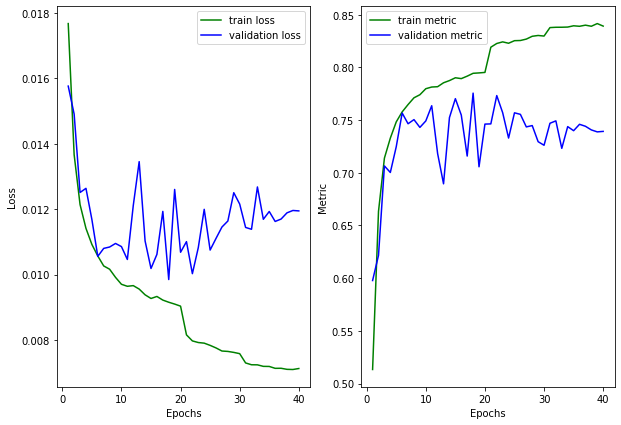

In [33]:
# plot training results (loss and accuracy vs epoch)
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [34]:
# load the best model
checkpoint = torch.load('./best_model.pth')
print('Best model at epoch: ', checkpoint['epoch'])

model = MyTransformer(**model_kwargs)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() 

Best model at epoch:  18


MyTransformer(
  (input_layer): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): GELU(approximate=none)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): GELU(approximate=none)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): GELU(approximate=none)
  )
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate=none)
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (

**Exercise:** loop over the test set and:
* compute the average accuracy
* save the predicted probability for each class in a torch tensor *pred_prob* of size *(test_set_events, 5)*
* save the predicted class in a torch tensor *pred_val* of size *(test_set_events,)*
* save the true class in in a torch tensor *ground_truth* of size *(test_set_events,)*

**Tipp:**
write a loop similar to the one used in the validation step of the training loop. Put tensors on GPU to speedup the computation.

NOTE: 
* example to create an empty torch tensor on the GPU: *torch.empty(size=(0,5), device=device)*
* example on how to concatenate two torch tensors along first dimension: *torch.cat((pred_prob, pre), dim=0)*

In [35]:
# inference on test set
pred_prob = torch.empty(size=(0,5), device=device) #note the device parameter, this allows to create the torch tensors in the needed device
pred_val = torch.empty(size=(0,), device=device)
ground_truth = torch.empty(size=(0,), device=device)

test_loss = 0.0
test_metric = 0.0
model.to(device)
counter=0
with torch.no_grad():
  for xb, yb in test_loader:
    counter += 1
    xb=xb.type(torch.float).to(device)
    yb=yb.type(torch.long).to(device)
    res = model(xb)
    pre = torch.softmax(res, dim=1)
    val = pre.argmax(dim=1)  
    pred_prob = torch.cat((pred_prob, pre), dim=0)
    pred_val = torch.cat((pred_val, val), dim=0)
    ground_truth = torch.cat((ground_truth, yb), dim=0) 
    vloss = loss_func(res, yb)
    vmetric = metric_func(res, yb)
    test_loss += vloss.item()
    test_metric += vmetric.item()

test_loss = test_loss/(counter*batch)
test_metric = test_metric/(counter*batch)  

predict_val = pred_val.cpu().data.numpy()
predict_prob = pred_prob.cpu().data.numpy()
true_val = ground_truth.cpu().data.numpy()

print('test loss: ', test_loss)
print('test average accuracy: ', test_metric)

test loss:  0.009724538631831543
test average accuracy:  0.7713607594936709


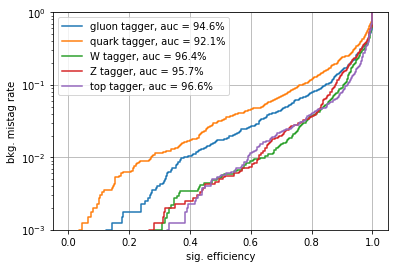

In [36]:
from sklearn.metrics import roc_curve, auc

# print ROC curves 
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve((true_val==i), predict_prob[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [37]:
#function to print a nice confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [38]:
# confusion matrix
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(true_val, predict_val, normalize='true')
print("Confusion Matrix:")
print("")
print_cm(c_mat,labels)

Confusion Matrix:

          gluon quark     W     Z   top 
    gluon  0.83  0.08  0.01  0.01  0.07 
    quark  0.18  0.69  0.02  0.03  0.08 
        W  0.03  0.10  0.76  0.10  0.01 
        Z  0.05  0.09  0.05  0.81  0.01 
      top  0.11  0.02  0.02  0.02  0.81 
